In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import zipfile
from PIL import Image
from io import BytesIO
from pathlib import Path
import matplotlib.pyplot as plt
from keras import layers
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

C:\Users\elon2\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\elon2\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\elon2\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
zip_path = os.getcwd()+'\\BS-data\\BTMI.zip'
healthy_path = r'Dataset/Brain Tumor MRI images/Healthy'
tumor_path = r'Dataset/Brain Tumor MRI images/Tumor'

In [3]:
def load_class_images(zip_path, class_path, target_size=(180, 180)):
    images = []
    with zipfile.ZipFile(zip_path) as zip_ref:
        for file in zip_ref.namelist():
            if file.startswith(class_path) and file.lower().endswith(('.png', '.jpg')):
                with zip_ref.open(file) as img_file:
                    # Convert to grayscale and resize
                    img = Image.open(BytesIO(img_file.read())).convert('RGB')
                    img = img.resize(target_size)
                    images.append(img)
    return np.array(images)

In [4]:
def plot_process(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, "bo", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

In [5]:
# Load both classes
healthy_images = load_class_images(zip_path, healthy_path)
tumor_images = load_class_images(zip_path, tumor_path)

# Create labels
X = np.concatenate([healthy_images, tumor_images])
y = np.array([0]*len(healthy_images) + [1]*len(tumor_images))

print(f"Total images: {len(X)} (Healthy: {len(healthy_images)}, Tumor: {len(tumor_images)})")
print(f"Image shape: {X[0].shape}")

Total images: 4981 (Healthy: 1997, Tumor: 2984)
Image shape: (180, 180, 3)


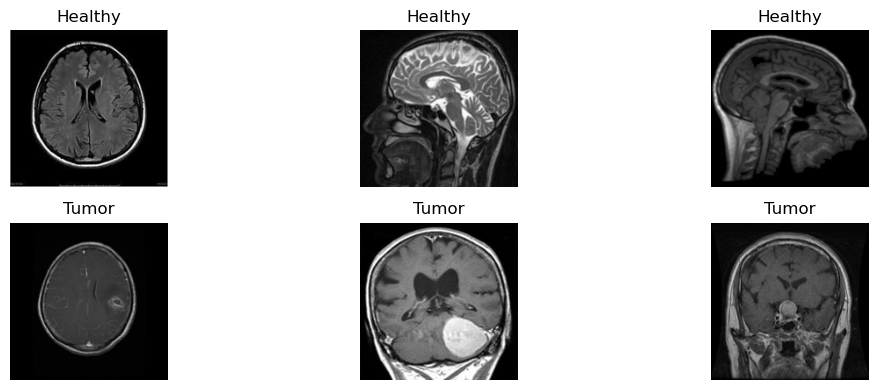

In [6]:
# Display sample images
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(healthy_images[random.randint(0, healthy_images.shape[0]-1)], cmap='gray')
    plt.title('Healthy')
    plt.axis('off')
for i in range(3):
    plt.subplot(2, 3, i+4)
    plt.imshow(tumor_images[random.randint(0, tumor_images.shape[0]-1)], cmap='gray')
    plt.title('Tumor')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

print(X_test.shape)
print(y_test.shape)

(3187, 180, 180, 3)
(3187,)
(797, 180, 180, 3)
(797,)
(997, 180, 180, 3)
(997,)


In [9]:
train_dataset = (X_train, y_train)
validation_dataset = (X_val, y_val)
test_dataset = (X_test, y_test)

## Model from Scratch

In [11]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
callbacks = [ModelCheckpoint(
        filepath= "from_scratch_mri.keras",
        save_best_only=True,
        monitor="val_loss")]

In [13]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(3187, 180, 180, 3) (3187,)
(797, 180, 180, 3) (797,)


In [14]:
history = model.fit(
    X_train,
    y_train,
    epochs = 30,
    validation_data = validation_dataset,
    callbacks = callbacks)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 69s 680ms/step - accuracy: 0.6130 - loss: 0.6920 - val_accuracy: 0.7754 - val_loss: 0.4721
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 69s 695ms/step - accuracy: 0.7949 - loss: 0.4544 - val_accuracy: 0.8821 - val_loss: 0.3072
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 71s 714ms/step - accuracy: 0.9003 - loss: 0.2632 - val_accuracy: 0.9310 - val_loss: 0.1877
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 70s 705ms/step - accuracy: 0.9456 - loss: 0.1530 - val_accuracy: 0.9486 - val_loss: 0.1517
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 70s 705ms/step - accuracy: 0.9621 - loss: 0.1111 - val_accuracy: 0.9686 - val_loss: 0.0811
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 75s 753ms/step - accuracy: 0.9767 - loss: 0.0689 - val_accuracy: 0.9724 - val_loss: 0.0947
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 70s 705ms/step - accuracy: 0.9839 - loss: 0.0538 - val_accuracy: 0.9774 - val_loss: 0.0838
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 70s 696ms/step - accuracy: 0.9864 - loss: 0

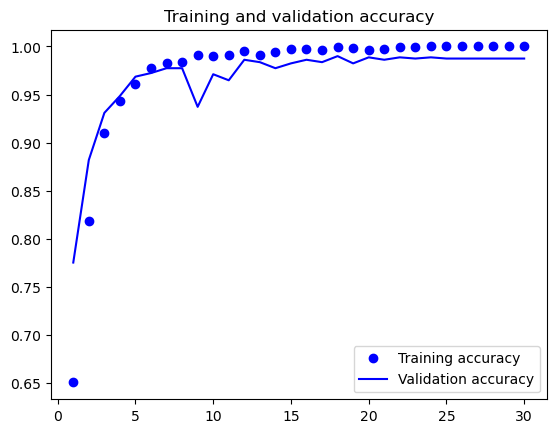

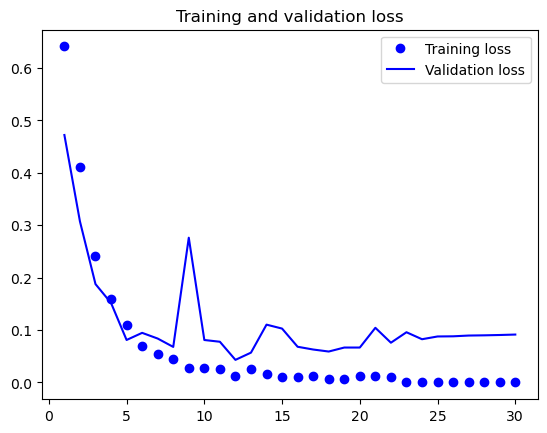

In [15]:
plot_process(history)

In [16]:
model.evaluate(X_test, y_test) 

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - accuracy: 0.9876 - loss: 0.1322


[0.1433417946100235, 0.9839518666267395]

In [17]:
best_model = load_model("from_scratch_mri.keras")
best_model.evaluate(X_test, y_test) 

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.9840 - loss: 0.0685


[0.0691506490111351, 0.981945812702179]

## Using Data Augmentation 

In [19]:
augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
        layers.RandomBrightness(0.2)
    ]
)

<IPython.core.display.Javascript object>

In [20]:
inputs = keras.Input(shape=(180, 180, 3))
x = augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="from_scratch_with_augmentation_mri.keras",
        save_best_only=True,
        monitor="val_loss")
]

<IPython.core.display.Javascript object>

In [22]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    validation_data = validation_dataset,
    callbacks=callbacks)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 78s 770ms/step - accuracy: 0.5722 - loss: 0.7123 - val_accuracy: 0.7578 - val_loss: 0.5238
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 76s 763ms/step - accuracy: 0.7062 - loss: 0.5734 - val_accuracy: 0.8519 - val_loss: 0.3712
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 75s 752ms/step - accuracy: 0.7970 - loss: 0.4456 - val_accuracy: 0.8582 - val_loss: 0.3689
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 78s 783ms/step - accuracy: 0.8343 - loss: 0.3886 - val_accuracy: 0.7892 - val_loss: 0.5160
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 818ms/step - accuracy: 0.8619 - loss: 0.3337 - val_accuracy: 0.9109 - val_loss: 0.2304
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 833ms/step - accuracy: 0.8791 - loss: 0.2967 - val_accuracy: 0.9435 - val_loss: 0.2123
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 796ms/step - accuracy: 0.8970 - loss: 0.2625 - val_accuracy: 0.9511 - val_loss: 0.1573
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 79s 794ms/step - accuracy: 0.9096 -

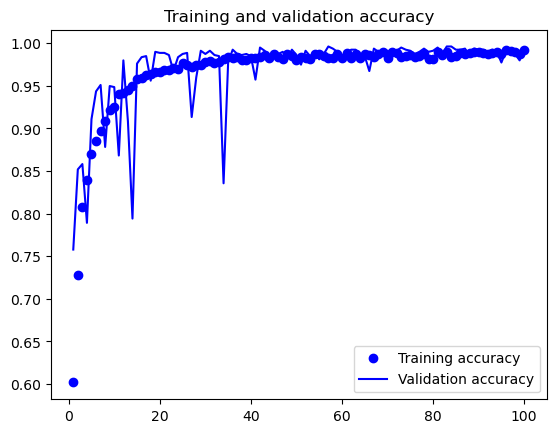

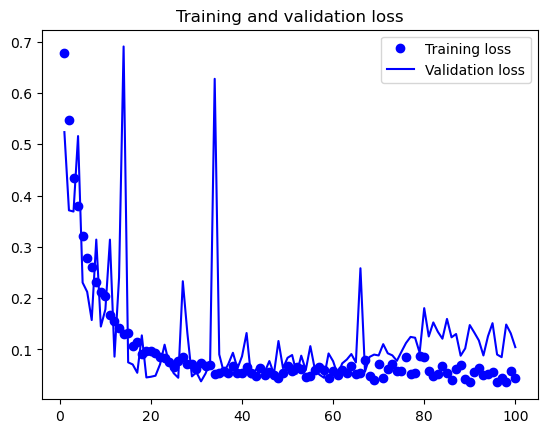

In [23]:
plot_process(history)

In [24]:
model.evaluate(X_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - accuracy: 0.9917 - loss: 0.1502


[0.21483096480369568, 0.9889668822288513]

In [25]:
best_model = load_model("from_scratch_with_augmentation_mri.keras")
best_model.evaluate(X_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.9820 - loss: 0.0683


[0.09642960876226425, 0.9749248027801514]

## Transfer learning

### VGG16:

In [28]:
conv_base_vgg = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

<IPython.core.display.Javascript object>

In [29]:
def get_features_and_labels(dataset):
    # Unpack the single tuple from dataset
    images, labels = dataset
    
    # Process the images
    preprocessed_images = keras.applications.vgg16.preprocess_input(images)
    features = conv_base_vgg.predict(preprocessed_images, verbose=0)
    return features, labels

In [30]:
train_dataset = (X_train, y_train)
validation_dataset = (X_val, y_val)
test_dataset = (X_test, y_test)

# Process datasets
train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
input_shape = train_features.shape[1:]

inputs = keras.Input(shape=input_shape)
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
# x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction_vgg16_mri.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=30,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8364 - loss: 27.8226 - val_accuracy: 0.9247 - val_loss: 4.5565
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9563 - loss: 2.5270 - val_accuracy: 0.9573 - val_loss: 2.0137
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9822 - loss: 0.4801 - val_accuracy: 0.9875 - val_loss: 0.4316
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9907 - loss: 0.1594 - val_accuracy: 0.9737 - val_loss: 0.5700
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9894 - loss: 0.1268 - val_accuracy: 0.9824 - val_loss: 0.2960
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9943 - loss: 0.0315 - val_accuracy: 0.9210 - val_loss: 1.1037
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9864 - loss: 0.1041 - val_accuracy: 0.9724 - val_loss: 0.4452
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9941 - loss: 0.0326 - val_acc

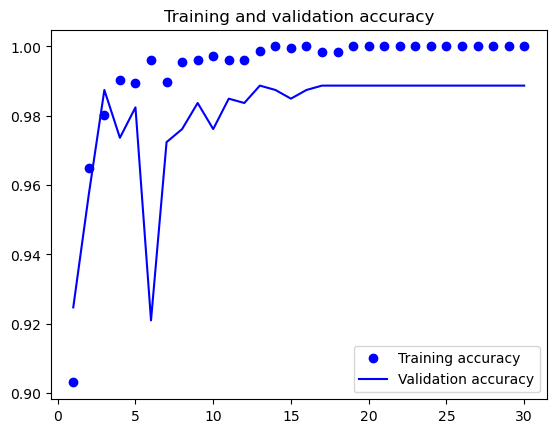

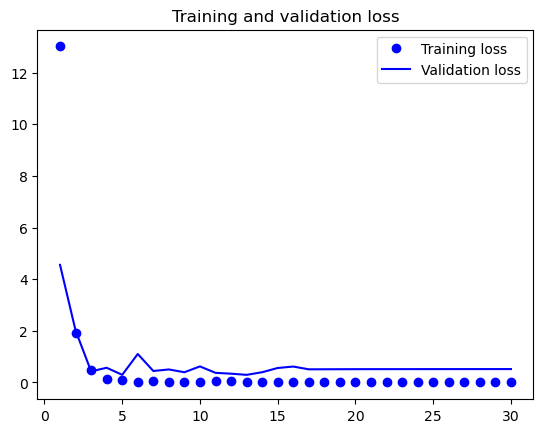

In [32]:
plot_process(history)

In [33]:
X_test.shape

(997, 180, 180, 3)

In [34]:
model.evaluate(test_features, test_labels)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9848 - loss: 0.5472


[0.6244827508926392, 0.9869608879089355]

In [35]:
best_model = load_model("feature_extraction_vgg16_mri.keras")
best_model.evaluate(test_features, test_labels)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9922 - loss: 0.3142  


[0.35850974917411804, 0.9909729361534119]

### VGG16 with Data Augmentation:

In [37]:
conv_base_vgg = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base_vgg.trainable = False

<IPython.core.display.Javascript object>

In [38]:
augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
        layers.RandomBrightness(0.2)
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base_vgg(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
# x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_augmentation_mri.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    X_train, y_train,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

<IPython.core.display.Javascript object>

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 369s 4s/step - accuracy: 0.7786 - loss: 40.7401 - val_accuracy: 0.9172 - val_loss: 5.2373
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 360s 4s/step - accuracy: 0.9031 - loss: 4.6186 - val_accuracy: 0.9285 - val_loss: 2.2040
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 356s 4s/step - accuracy: 0.9458 - loss: 0.7523 - val_accuracy: 0.9435 - val_loss: 0.2591
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 356s 4s/step - accuracy: 0.9347 - loss: 0.2952 - val_accuracy: 0.9724 - val_loss: 0.1286
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 357s 4s/step - accuracy: 0.9492 - loss: 0.1683 - val_accuracy: 0.9649 - val_loss: 0.2467
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 358s 4s/step - accuracy: 0.9542 - loss: 0.1859 - val_accuracy: 0.9799 - val_loss: 0.1218
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 361s 4s/step - accuracy: 0.9570 - loss: 0.1333 - val_accuracy: 0.9737 - val_loss: 0.0985
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 358s 4s/step - accuracy: 0.9609 - loss: 0.1324 - val_acc

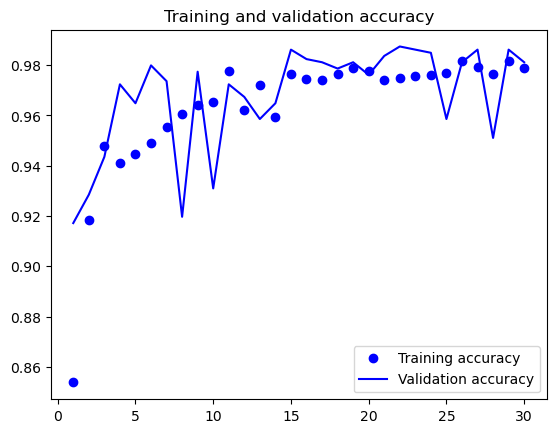

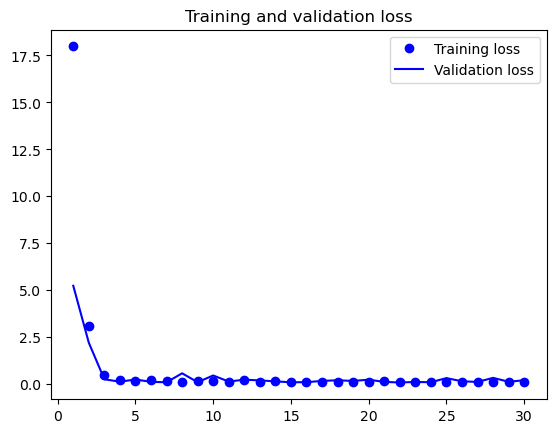

In [40]:
plot_process(history)

In [41]:
best_model = load_model("feature_extraction_with_augmentation_mri.keras")
best_model.evaluate(X_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.9781 - loss: 0.1685


[0.15419629216194153, 0.9809428453445435]

### Fine Tuning Pretrained Model:

In [43]:
conv_base_vgg.trainable = True
for layer in conv_base_vgg.layers[:-4]:
    layer.trainable = False

In [44]:
best_model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning_vgg_mri.keras",
        save_best_only=True,
        monitor="val_loss")
]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [45]:
history = best_model.fit(
    X_train, y_train,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 327s 3s/step - accuracy: 0.9888 - loss: 0.0749 - val_accuracy: 0.9849 - val_loss: 0.0859
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 330s 3s/step - accuracy: 0.9914 - loss: 0.0566 - val_accuracy: 0.9862 - val_loss: 0.0851
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 327s 3s/step - accuracy: 0.9884 - loss: 0.0402 - val_accuracy: 0.9862 - val_loss: 0.0820
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - accuracy: 0.9871 - loss: 0.0694 - val_accuracy: 0.9837 - val_loss: 0.0788
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - accuracy: 0.9890 - loss: 0.0533 - val_accuracy: 0.9862 - val_loss: 0.0763
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 326s 3s/step - accuracy: 0.9907 - loss: 0.0374 - val_accuracy: 0.9849 - val_loss: 0.0732
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 326s 3s/step - accuracy: 0.9889 - loss: 0.0616 - val_accuracy: 0.9862 - val_loss: 0.0735
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 325s 3s/step - accuracy: 0.9891 - loss: 0.0419 - val_accu

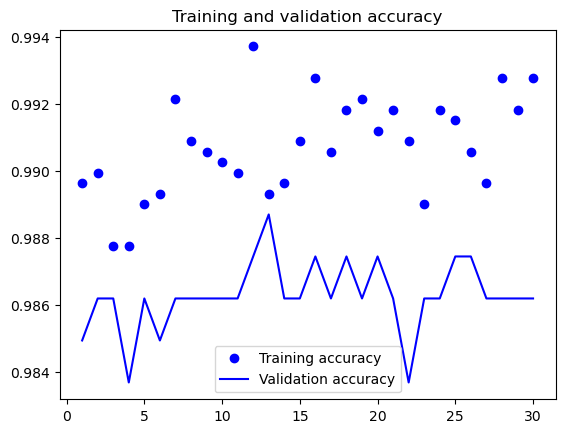

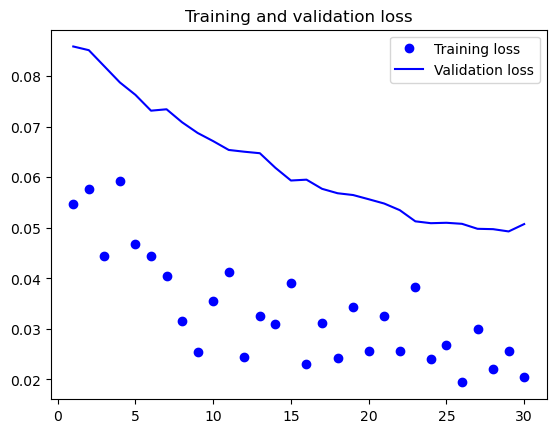

In [46]:
plot_process(history)

In [47]:
best_model.evaluate(X_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.9821 - loss: 0.1006


[0.09670016914606094, 0.9839518666267395]

In [48]:
best_model = load_model("fine_tuning_vgg_mri.keras")
best_model.evaluate(X_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.9821 - loss: 0.0987


[0.09421531111001968, 0.9839518666267395]

* Seems like there is space for improvement with more epochs

In [50]:
history = best_model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 357s 4s/step - accuracy: 0.9932 - loss: 0.0154 - val_accuracy: 0.9862 - val_loss: 0.0493
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 356s 4s/step - accuracy: 0.9871 - loss: 0.0454 - val_accuracy: 0.9862 - val_loss: 0.0488
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 358s 4s/step - accuracy: 0.9905 - loss: 0.0279 - val_accuracy: 0.9862 - val_loss: 0.0475
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 356s 4s/step - accuracy: 0.9900 - loss: 0.0327 - val_accuracy: 0.9862 - val_loss: 0.0471
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 351s 4s/step - accuracy: 0.9925 - loss: 0.0168 - val_accuracy: 0.9849 - val_loss: 0.0474
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 354s 4s/step - accuracy: 0.9928 - loss: 0.0245 - val_accuracy: 0.9875 - val_loss: 0.0481
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 353s 4s/step - accuracy: 0.9929 - loss: 0.0195 - val_accuracy: 0.9849 - val_loss: 0.0484
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 356s 4s/step - accuracy: 0.9860 - loss: 0.0396 - val_accu

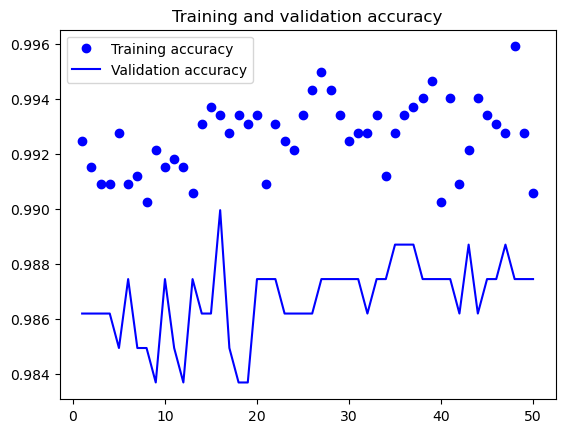

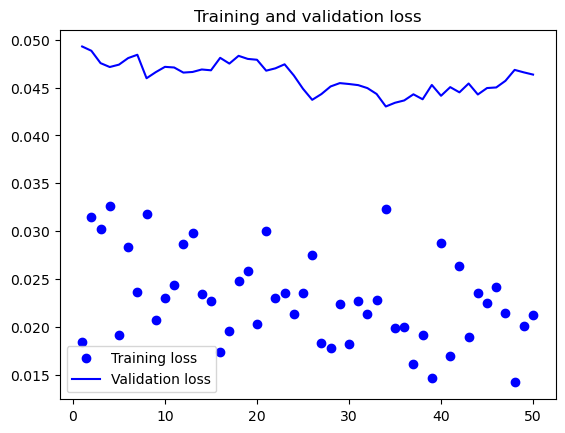

In [51]:
plot_process(history)

In [52]:
best_model = load_model("fine_tuning_vgg_mri.keras")
best_model.evaluate(X_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.9839 - loss: 0.0926


[0.08348346501588821, 0.9889668822288513]

---

## Results analysis

In [278]:
from IPython.display import display

In [279]:
def generate_classification_reports(model_path, threshold = 0.5, pretrained=False):
    model_name = model_path[:-6]  # remove `keras` suffix
    print(f"{model_name}:\n")
    model = load_model(model_path)
    if pretrained:
        y_pred = model.predict(test_features)
    else:
        y_pred = model.predict(X_test)
        
    y_pred = (y_pred > threshold).astype(int)

    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'Blues', display_labels= ['Healthy','Positive'])
    plt.title(f"\nConfusion Matrix - {model_name}")  
    plt.gcf().set_size_inches(6, 4)
    plt.show()
    
    clf_report = classification_report(y_test, y_pred, output_dict=True, target_names = ['Healthy','Positive'], digits = 4)

    return clf_report

In [280]:
def format_and_extract(clf):
    '''
    Defining evaluation metric as recall of true positives
    It is preffered to detect correctly as many as possible, even at the cost of a few false positives
    '''
    df = pd.DataFrame(clf).round(3)
    acc = df.iloc[1,2]
    df = df.drop(columns = ['accuracy'])
    score = df.loc["recall","Positive"]
    return df, acc, score

In [281]:
models = ['from_scratch_mri.keras',
          'from_scratch_with_augmentation_mri.keras', 
          'feature_extraction_vgg16_mri.keras',
          'feature_extraction_with_augmentation_mri.keras',
          'fine_tuning_vgg_mri.keras'
         ]

from_scratch_mri:

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 373ms/step


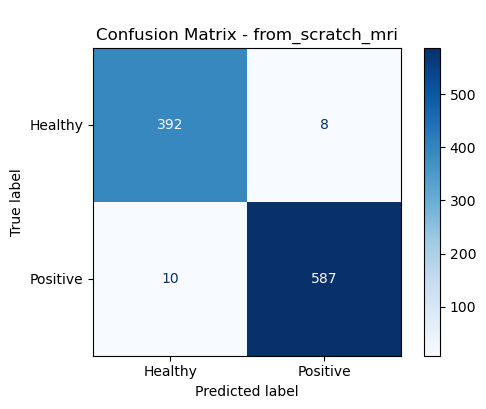

<IPython.core.display.Javascript object>

,Healthy,Positive,macro avg,weighted avg
precision,0.975,0.987,0.981,0.982
recall,0.980,0.983,0.982,0.982
f1-score,0.978,0.985,0.981,0.982
support,400.000,597.000,997.000,997.000




from_scratch_with_augmentation_mri:

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 379ms/step


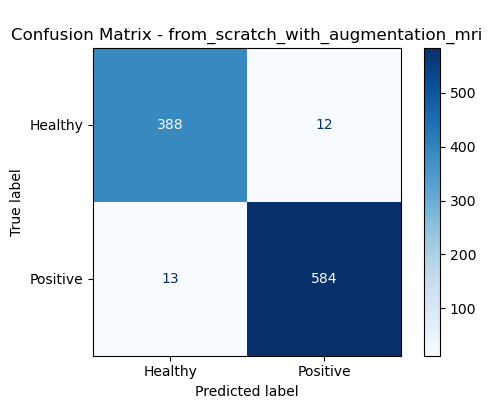

<IPython.core.display.Javascript object>

,Healthy,Positive,macro avg,weighted avg
precision,0.968,0.980,0.974,0.975
recall,0.970,0.978,0.974,0.975
f1-score,0.969,0.979,0.974,0.975
support,400.000,597.000,997.000,997.000




feature_extraction_vgg16_mri:

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


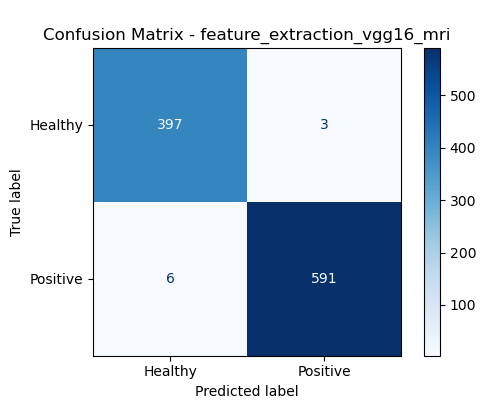

<IPython.core.display.Javascript object>

,Healthy,Positive,macro avg,weighted avg
precision,0.985,0.995,0.990,0.991
recall,0.992,0.990,0.991,0.991
f1-score,0.989,0.992,0.991,0.991
support,400.000,597.000,997.000,997.000




feature_extraction_with_augmentation_mri:

32/32 ━━━━━━━━━━━━━━━━━━━━ 164s 5s/step


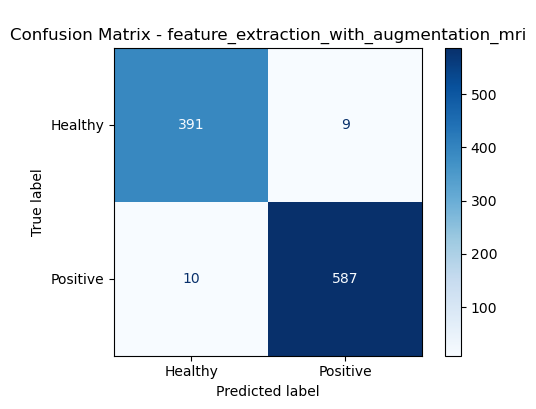

<IPython.core.display.Javascript object>

,Healthy,Positive,macro avg,weighted avg
precision,0.975,0.985,0.98,0.981
recall,0.978,0.983,0.98,0.981
f1-score,0.976,0.984,0.98,0.981
support,400.000,597.000,997.00,997.000




fine_tuning_vgg_mri:

32/32 ━━━━━━━━━━━━━━━━━━━━ 179s 6s/step


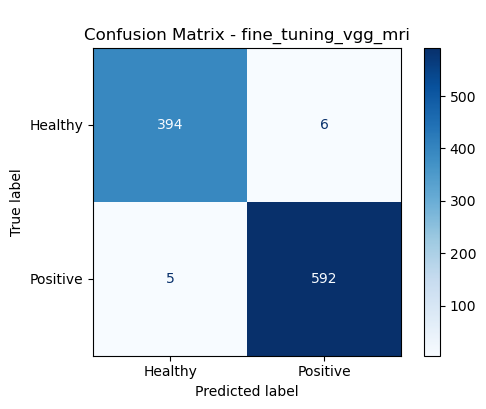

<IPython.core.display.Javascript object>

,Healthy,Positive,macro avg,weighted avg
precision,0.987,0.990,0.989,0.989
recall,0.985,0.992,0.988,0.989
f1-score,0.986,0.991,0.989,0.989
support,400.000,597.000,997.000,997.000


In [282]:
scores = {}
acc_scores = {}
for m in models:
    pretrained = (m=='feature_extraction_vgg16.keras') or (m=='feature_extraction_vgg16_mri.keras')
    clf_report = generate_classification_reports(m, 0.5 ,pretrained = pretrained)
    df, acc, score = format_and_extract(clf_report)
    m = m[:-6]
    scores[m] = score
    acc_scores[m] = acc
    display(df)
    print("==============================================================================\n\n")


In [283]:
acc_df = pd.DataFrame(acc_scores, index = ['Accuracy']).T.sort_values('Accuracy', ascending = False)
positive_recall_df = pd.DataFrame(scores, index = ['Positive recall']).T.sort_values('Positive recall', ascending = False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [284]:
display(acc_df)
display(positive_recall_df)

,Accuracy
feature_extraction_vgg16_mri,0.991
fine_tuning_vgg_mri,0.989
from_scratch_mri,0.982
feature_extraction_with_augmentation_mri,0.981
from_scratch_with_augmentation_mri,0.975


,Positive recall
fine_tuning_vgg_mri,0.992
feature_extraction_vgg16_mri,0.990
from_scratch_mri,0.983
feature_extraction_with_augmentation_mri,0.983
from_scratch_with_augmentation_mri,0.978


---